In [1]:
%matplotlib widget
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8-darkgrid')

In [37]:
data = lk.search_lightcurve('TIC 3034524', mission='TESS')
lightcurve = data[0].download_all(quality_bitmask='hardest').stitch(corrector_func=lambda x: x)

# hard_data = data[0].download_all(quality_bitmask='hardest').stitch(corrector_func=lambda x: x)

data


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 19,2019,SPOC,120,3034524,0.0
1,TESS Sector 43,2021,SPOC,120,3034524,0.0
2,TESS Sector 44,2021,SPOC,120,3034524,0.0
3,TESS Sector 45,2021,SPOC,120,3034524,0.0
4,TESS Sector 59,2022,SPOC,120,3034524,0.0
5,TESS Sector 71,2023,SPOC,120,3034524,0.0
6,TESS Sector 73,2023,SPOC,120,3034524,0.0
7,TESS Sector 19,2019,TESS-SPOC,1800,3034524,0.0
8,TESS Sector 43,2021,TESS-SPOC,600,3034524,0.0


In [52]:
x = np.array(lightcurve.time.btjd)
y = np.array(lightcurve.flux)

mask_valid = ~np.isnan(y) & ~np.isinf(y)
x = x[mask_valid]
y = y[mask_valid]

w = abs(y)

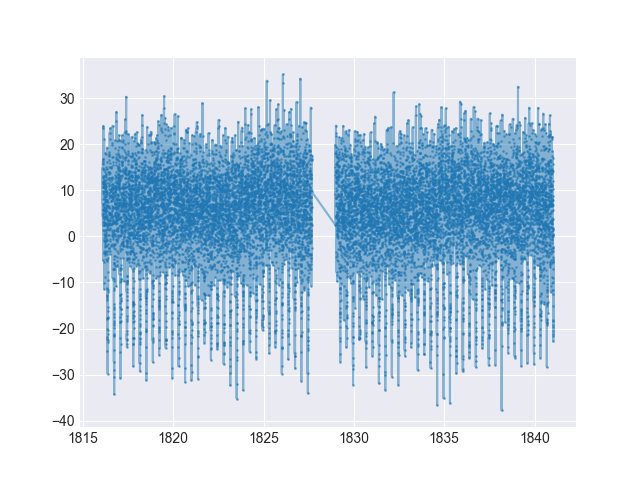

In [48]:
plt.figure()
plt.plot(x, y, marker='o', label='Raw Data', markersize=1, alpha= 0.5)

In [49]:
plt.plot(x, y**2, marker='o', label='Raw Data Squared', markersize=1, alpha= 0.5, color='red')
plt.plot(x, w**(1/2), marker='o', label='Raw Data Squared', markersize=1, alpha= 0.5, color='green')

In [53]:
lightcurvedf = pd.DataFrame({'time': x, 'flux': y})
lightcurvedf['flux'] = lightcurvedf['flux'].astype(float)

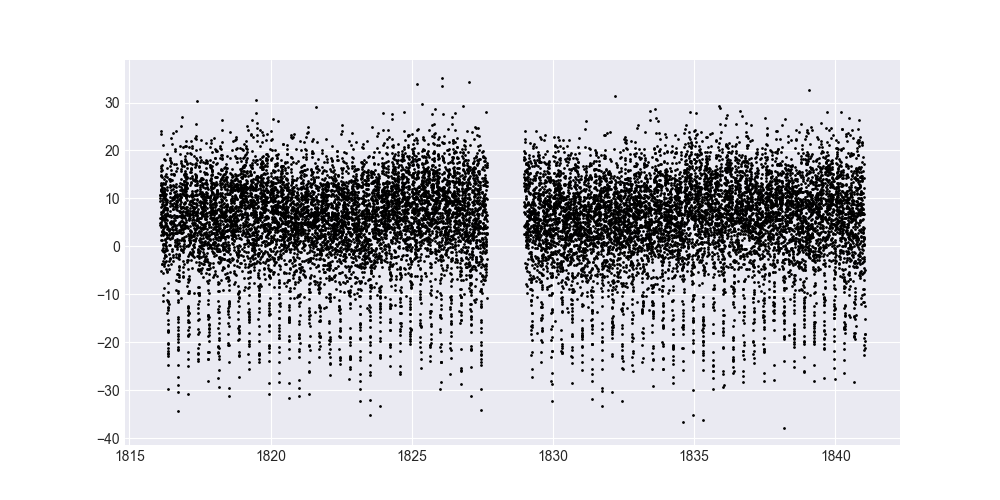

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(lightcurvedf['time'], lightcurvedf['flux'], 'k.', markersize=2)

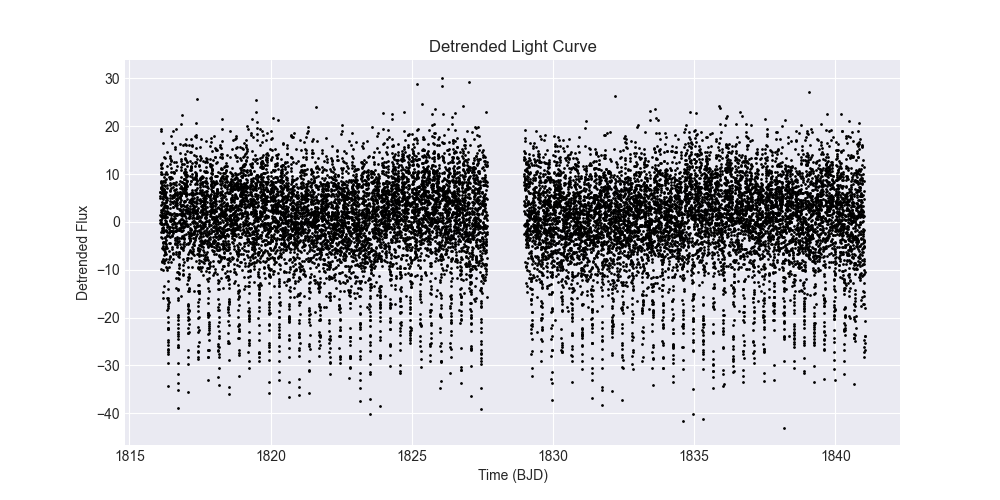

In [60]:
z = np.polyfit(lightcurvedf['time'], lightcurvedf['flux'], deg=3)  # Degree 2 for a quadratic trend
p = np.poly1d(z)

# Detrend the light curve
lightcurvedf['flux_detrended'] = lightcurvedf['flux'] - p(lightcurvedf['time'])

# Plot detrended light curve
plt.figure(figsize=(10, 5))
plt.plot(lightcurvedf['time'], lightcurvedf['flux_detrended'], 'k.', markersize=2)
plt.xlabel('Time (BJD)')
plt.ylabel('Detrended Flux')
plt.title('Detrended Light Curve')
plt.show()

lightcurvedf.to_csv('lightcurveisshh.csv', index=False)

In [6]:
# Calculate standard deviation and mean of flux
std_dev = lightcurvedf['flux'].std()
mean = lightcurvedf['flux'].mean()

plt.axhline(mean, color='r', linestyle='-.', label='Mean')
plt.axhline(mean - std_dev, color='g', linestyle='-.', label='Mean - 1 Std Dev')
plt.axhline(mean - (1.5*std_dev), color='black', linestyle='-.', label='Mean + 1.5 Std Dev')

# Create a new DataFrame with values that are at least 1.5 standard deviations below the mean
low_lightcurvedf = lightcurvedf[lightcurvedf['flux'] <= mean - (1 * std_dev)]
lower_lightcurvedf = lightcurvedf[lightcurvedf['flux'] <= mean - (1.5 * std_dev)]

In [7]:
lightcurvedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    16741 non-null  float64
 1   flux    16741 non-null  float64
dtypes: float64(2)
memory usage: 261.7 KB


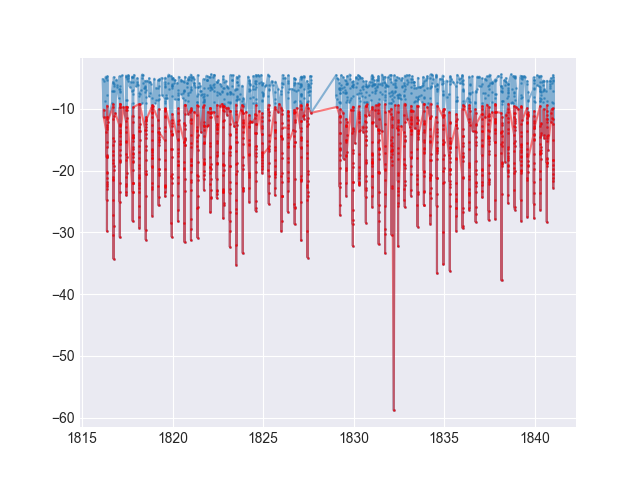

In [8]:
plt.figure()
plt.plot(low_lightcurvedf['time'], low_lightcurvedf['flux'], marker='o', label='Low Data', markersize=1, alpha=0.5)
plt.plot(lower_lightcurvedf['time'], lower_lightcurvedf['flux'], marker='o', label='Lower Data', markersize=1, alpha=0.5, color='r')

In [9]:
lightcurvedf.to_csv('lightcurveish.csv', index=False)

In [10]:
# Threshold method
threshold = lightcurvedf['flux'].mean() - lightcurvedf['flux'].std()  # Example threshold
lightcurvedf['eclipse'] = (lightcurvedf['flux'] < threshold).astype(int)

lightcurvedf['eclipse_event'] = lightcurvedf['eclipse'].diff().fillna(0).astype(int)
lightcurvedf['eclipse_label'] = (lightcurvedf['eclipse_event'] == 1).cumsum()

lightcurvedf = lightcurvedf[lightcurvedf['eclipse'] == 1]



17
22
14
9
21
23
21
15
19
19
10
12
16
18
17
21
20
20
18
18
24
18
21
19
15
15
9
20
17
12
8
16
21
15
26
7
12
19
22
21
13
22
6
18
18
10
9
17
12
6
19
20
23
20
24
10
15
24
15
21
18
14
18
21
15
12
20
24
6
12
17
18
19
14
11


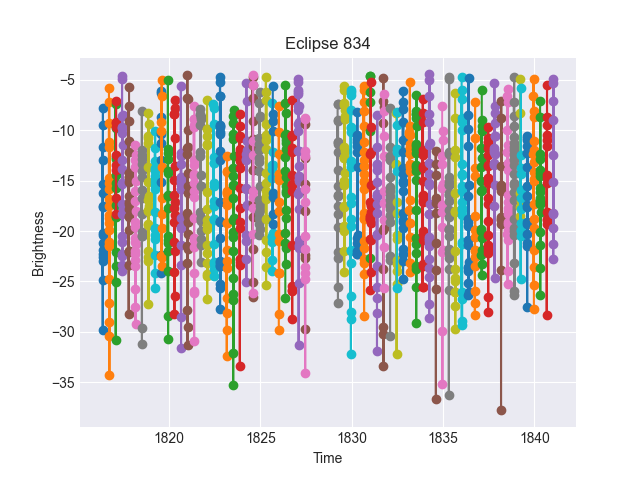

In [28]:
def inverted_gaussian(x, a, b, c):
    return a - a * np.exp(-((x-b)**2) / (2*c**2))

eclipse_groups = lightcurvedf.groupby('eclipse_label')
plt.figure()
for name, group in eclipse_groups:
    if name > 0 and len(group) > 5:  # name == 0 are the non-eclipse periods
        print(len(group))
        plt.plot(group['time'], group['flux'], marker='o', linestyle='-')
        plt.title(f'Eclipse {name}')
        plt.xlabel('Time')
        plt.ylabel('Brightness')

        # print(group)

        # initial_guess = [-1, group['time'].mean(), group['flux'].std()]
        # popt, pcov = curve_fit(inverted_gaussian, group['time'], group['flux'], p0=initial_guess)

        # print(inverted_gaussian(group['time'], *popt))
        # print(*popt)

        # plt.plot(group['time'], inverted_gaussian(group['time'], *popt), 'r-', label='Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

        # break


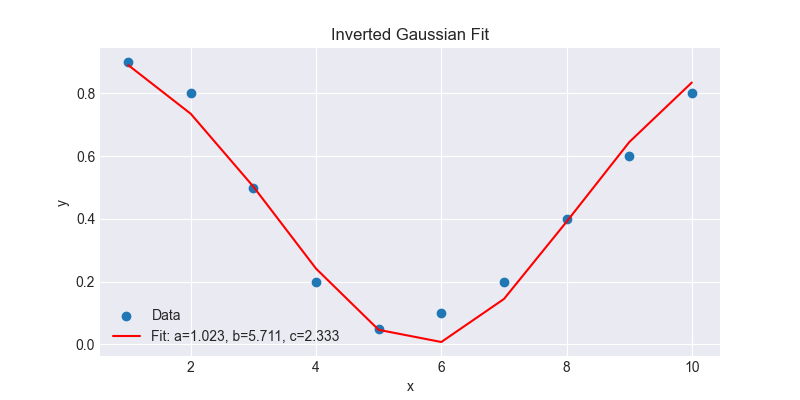

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data (replace these with your actual data)
xdata = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ydata = np.array([0.9, 0.8, 0.5, 0.2, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])

# Define the inverted Gaussian function
def inverted_gaussian(x, a, b, c):
    return a - a * np.exp(-((x-b)**2) / (2*c**2))

# Initial guess for the parameters: [amplitude, mean, std deviation]
initial_guess = [1, xdata.mean(), ydata.std()]

# Perform the curve fitting
popt, pcov = curve_fit(inverted_gaussian, xdata, ydata, p0=initial_guess)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, inverted_gaussian(xdata, *popt), 'r-', label='Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.title('Inverted Gaussian Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
